In [3]:
import requests
import pandas as pd
import time
from datetime import datetime, timedelta
import csv
import os
from bs4 import BeautifulSoup
import random

# Configuration
TICKERS_FILE = "tickers.csv"  # CSV with 'ticker' column (first row is header)
OUTPUT_CSV = "sentiments.csv"
LOG_FILE = "api_collection_log.txt"
BASE_URL = "https://www.alphavantage.co/query"

# List of available API keys
API_KEYS = [
    "FGOQZIJERIPFRFF1", "61WAV92NHLSDUKPL", "QI5II79A07WJ6DSW", "EKWCWBIKOWLP7DOB",
    "HT8TZULZ4OCMIQZS", "ZEAHHSYNWTYR38O1", "QPTB2NLPU5D61B42", "BC2MNDBLAS76D68L",
    "NEDB84ME1BJK8NVM", "4OE65LES77WGJ1R8", "GKARODGZW9Q0COEP", "0H2VZ7AH77Y3QZ92",
    "2EZRM05T9HBAKBD0", "0IIGUV8LWWN1NSFX", "YILMNMDG798R23TU", "TVSD1FR53XIAI0MQ",
    "38IAPSWJIECCMG5V", "9GVYEEBAXW6C7LMH", "34Z9ZK60FA9KJHQL", "7ZDEC5ST635U07PO",
    "14O99BFD3CM8HIVB", "TGAHD9DJ0M03OMNM", "Y7YR6OVFXIOTARX6", "24NSNTRD7XOOY3JD",
    "ANFCS45K2NDOA5SA", "U2K8H6CA0Z3UJQD6", "N7DEUFWPL7X611QO", "3YE9UECQ44U8EFE9",
    "LAVC0BUZ8A501I1L", "OODWF0OD831V8MA5", "U8FDOL9VBHGEI2WT", "YGCRS2Y7ZAD5YIMV",
    "BFWBPCIKQ09RYVOJ", "I8AKWUC8GVLAUC9W", "K5QU5CCFO8DC667Y", "K8AT69HSTUOQB27Z",
    "L4WOEFT2G0535PGN", "536G3LA8CV4DIDW0", "DGXAV4MPKIJZDZA1", "J2P8NVPUV6A7I391",
    "CB1I2CHIS2L5Y6VR", "U9EXAOHL2MXISSRT", "U0WQXFR53WHAT0V4", "DZM6SCVWC5P9AMW9",
    "4OP1Z32ZJRAV7L5E", "CDY2Z85IKKMPLPJH", "9OO49WDS9P1C37C5", "Z103NL244OC5C40N"
]

def load_tickers():
    """Load tickers from CSV file, skipping header"""
    df = pd.read_csv(TICKERS_FILE)
    return df['Ticker'].tolist()

def setup_output_csv():
    """Initialize output CSV with headers if it doesn't exist"""
    headers = [
        'ticker', 'title', 'url', 'time_published', 'authors', 'summary',
        'banner_image', 'source', 'category_within_source', 'source_domain',
        'overall_sentiment_score', 'overall_sentiment_label',
        'ticker_relevance_score', 'ticker_sentiment_score', 'ticker_sentiment_label',
        'topics', 'relevance_scores'
    ]
    
    if not os.path.exists(OUTPUT_CSV):
        with open(OUTPUT_CSV, 'w', newline='', encoding='utf-8') as f:
            writer = csv.writer(f)
            writer.writerow(headers)

def get_news_for_ticker(ticker, api_key, time_from=None, time_to=None):
    """Get news sentiment data for a single ticker"""
    params = {
        'function': 'NEWS_SENTIMENT',
        'tickers': ticker,
        'apikey': api_key,
        'sort': 'LATEST',
        'limit': 1000
    }
    
    if time_from:
        params['time_from'] = time_from.strftime("%Y%m%dT%H%M")
    if time_to:
        params['time_to'] = time_to.strftime("%Y%m%dT%H%M")
    
    try:
        response = requests.get(BASE_URL, params=params)
        response.raise_for_status()
        return response.json()
    except Exception as e:
        log_error(f"Error fetching data for {ticker}: {str(e)}")
        return None

def process_news_item(ticker, item):
    """Process a single news item into CSV row format"""
    # Extract base fields
    row = {
        'ticker': ticker,
        'title': item.get('title', ''),
        'url': item.get('url', ''),
        'time_published': item.get('time_published', ''),
        'authors': '|'.join(item.get('authors', [])),
        'summary': item.get('summary', ''),
        'banner_image': item.get('banner_image', ''),
        'source': item.get('source', ''),
        'category_within_source': item.get('category_within_source', ''),
        'source_domain': item.get('source_domain', ''),
        'overall_sentiment_score': item.get('overall_sentiment_score', ''),
        'overall_sentiment_label': item.get('overall_sentiment_label', '')
    }
    
    # Find ticker-specific sentiment
    ticker_sentiment_info = next(
        (ts for ts in item.get('ticker_sentiment', []) if ts['ticker'] == ticker),
        None
    )
    
    if ticker_sentiment_info:
        row.update({
            'ticker_relevance_score': ticker_sentiment_info.get('relevance_score', ''),
            'ticker_sentiment_score': ticker_sentiment_info.get('ticker_sentiment_score', ''),
            'ticker_sentiment_label': ticker_sentiment_info.get('ticker_sentiment_label', '')
        })
    else:
        row.update({
            'ticker_relevance_score': '',
            'ticker_sentiment_score': '',
            'ticker_sentiment_label': ''
        })
    
    # Process topics
    topics = []
    relevance_scores = []
    for topic in item.get('topics', []):
        topics.append(topic.get('topic', ''))
        relevance_scores.append(topic.get('relevance_score', ''))
    
    row['topics'] = '|'.join(topics)
    row['relevance_scores'] = '|'.join(relevance_scores)
    
    return row

def save_to_csv(data):
    """Append processed data to CSV"""
    with open(OUTPUT_CSV, 'a', newline='', encoding='utf-8') as f:
        writer = csv.DictWriter(f, fieldnames=data.keys())
        writer.writerow(data)

def log_error(message):
    """Log errors to file"""
    with open(LOG_FILE, 'a') as f:
        f.write(f"{datetime.now()}: {message}\n")

def main():
    tickers = load_tickers()
    setup_output_csv()
    
    current_api_key_index = 0
    requests_remaining = 0
    processed_tickers = 0
    
    # Get date range for last 5 years
    end_date = datetime.now()
    start_date = end_date - timedelta(days=5*365)
    
    for i, ticker in enumerate(tickers):
        # Get new API key if needed
        if requests_remaining <= 0:
            if current_api_key_index >= len(API_KEYS):
                log_error("All API keys exhausted, exiting")
                break
                
            current_api_key = API_KEYS[current_api_key_index]
            current_api_key_index += 1
            requests_remaining = 25
            log_error(f"Using new API key: {current_api_key[:5]}... (requests remaining: {requests_remaining})")
        
        print(f"Processing {i+1}/{len(tickers)}: {ticker}")
        
        # Get news in yearly chunks to maximize data per request
        current_start = start_date
        while current_start < end_date:
            current_end = min(current_start + timedelta(days=365), end_date)
            
            data = get_news_for_ticker(ticker, current_api_key, current_start, current_end)
            requests_remaining -= 1
            processed_tickers += 1
            
            # Respect rate limits (5 requests/minute)
            time.sleep(12)  # 12 seconds between requests to stay under 5/minute
            
            if data and 'feed' in data:
                for item in data['feed']:
                    processed = process_news_item(ticker, item)
                    save_to_csv(processed)
            
            current_start = current_end + timedelta(days=1)
            
            # Check if we've processed 25 tickers with this key
            if processed_tickers >= 25:
                processed_tickers = 0
                break  # break out of date loop to get new key

if __name__ == "__main__":
    main()

Processing 1/3300: AACB


KeyboardInterrupt: 

In [1]:
import requests
import pandas as pd
from datetime import datetime, timedelta
import csv
import os
from concurrent.futures import ThreadPoolExecutor, as_completed
import threading

# Configuration
TICKERS_FILE = "tickers.csv"  # CSV with 'Ticker' column (first row is header)
OUTPUT_CSV = "sentiments.csv"
LOG_FILE = "api_collection_log.txt"
BASE_URL = "https://www.alphavantage.co/query"
MAX_THREADS = 5  # Adjust based on your network capacity

# List of available API keys
API_KEYS = [
    "FGOQZIJERIPFRFF1", "61WAV92NHLSDUKPL", "QI5II79A07WJ6DSW", "EKWCWBIKOWLP7DOB",
    "HT8TZULZ4OCMIQZS", "ZEAHHSYNWTYR38O1", "QPTB2NLPU5D61B42", "BC2MNDBLAS76D68L",
    "NEDB84ME1BJK8NVM", "4OE65LES77WGJ1R8", "GKARODGZW9Q0COEP", "0H2VZ7AH77Y3QZ92",
    "2EZRM05T9HBAKBD0", "0IIGUV8LWWN1NSFX", "YILMNMDG798R23TU", "TVSD1FR53XIAI0MQ",
    "38IAPSWJIECCMG5V", "9GVYEEBAXW6C7LMH", "34Z9ZK60FA9KJHQL", "7ZDEC5ST635U07PO",
    "14O99BFD3CM8HIVB", "TGAHD9DJ0M03OMNM", "Y7YR6OVFXIOTARX6", "24NSNTRD7XOOY3JD",
    "ANFCS45K2NDOA5SA", "U2K8H6CA0Z3UJQD6", "N7DEUFWPL7X611QO", "3YE9UECQ44U8EFE9",
    "LAVC0BUZ8A501I1L", "OODWF0OD831V8MA5", "U8FDOL9VBHGEI2WT", "YGCRS2Y7ZAD5YIMV",
    "BFWBPCIKQ09RYVOJ", "I8AKWUC8GVLAUC9W", "K5QU5CCFO8DC667Y", "K8AT69HSTUOQB27Z",
    "L4WOEFT2G0535PGN", "536G3LA8CV4DIDW0", "DGXAV4MPKIJZDZA1", "J2P8NVPUV6A7I391",
    "CB1I2CHIS2L5Y6VR", "U9EXAOHL2MXISSRT", "U0WQXFR53WHAT0V4", "DZM6SCVWC5P9AMW9",
    "4OP1Z32ZJRAV7L5E", "CDY2Z85IKKMPLPJH", "9OO49WDS9P1C37C5", "Z103NL244OC5C40N"
]

# Thread-safe API key management
class APIKeyManager:
    def __init__(self, api_keys):
        self.api_keys = api_keys
        self.current_index = 0
        self.counters = [0] * len(api_keys)
        self.lock = threading.Lock()
    
    def get_key(self):
        with self.lock:
            # Find first key with remaining requests
            for i in range(len(self.api_keys)):
                key_index = (self.current_index + i) % len(self.api_keys)
                if self.counters[key_index] < 25:
                    self.counters[key_index] += 1
                    self.current_index = (key_index + 1) % len(self.api_keys)
                    return self.api_keys[key_index]
            return None  # All keys exhausted

def load_tickers():
    """Load tickers from CSV file"""
    df = pd.read_csv(TICKERS_FILE)
    return df['Ticker'].tolist()

def setup_output_csv():
    """Initialize output CSV with headers if it doesn't exist"""
    headers = [
        'ticker', 'title', 'url', 'time_published', 'authors', 'summary',
        'banner_image', 'source', 'category_within_source', 'source_domain',
        'overall_sentiment_score', 'overall_sentiment_label',
        'ticker_relevance_score', 'ticker_sentiment_score', 'ticker_sentiment_label',
        'topics', 'relevance_scores'
    ]
    
    if not os.path.exists(OUTPUT_CSV):
        with open(OUTPUT_CSV, 'w', newline='', encoding='utf-8') as f:
            writer = csv.writer(f)
            writer.writerow(headers)

def get_news_for_ticker(ticker, api_key, time_from=None, time_to=None):
    """Get news sentiment data for a single ticker"""
    params = {
        'function': 'NEWS_SENTIMENT',
        'tickers': ticker,
        'apikey': api_key,
        'sort': 'LATEST',
        'limit': 1000
    }
    
    if time_from:
        params['time_from'] = time_from.strftime("%Y%m%dT%H%M")
    if time_to:
        params['time_to'] = time_to.strftime("%Y%m%dT%H%M")
    
    try:
        response = requests.get(BASE_URL, params=params)
        response.raise_for_status()
        return response.json()
    except Exception as e:
        log_error(f"Error fetching data for {ticker}: {str(e)}")
        return None

def process_news_item(ticker, item):
    """Process a single news item into CSV row format"""
    row = {
        'ticker': ticker,
        'title': item.get('title', ''),
        'url': item.get('url', ''),
        'time_published': item.get('time_published', ''),
        'authors': '|'.join(item.get('authors', [])),
        'summary': item.get('summary', ''),
        'banner_image': item.get('banner_image', ''),
        'source': item.get('source', ''),
        'category_within_source': item.get('category_within_source', ''),
        'source_domain': item.get('source_domain', ''),
        'overall_sentiment_score': item.get('overall_sentiment_score', ''),
        'overall_sentiment_label': item.get('overall_sentiment_label', '')
    }
    
    ticker_sentiment_info = next(
        (ts for ts in item.get('ticker_sentiment', []) if ts['ticker'] == ticker),
        None
    )
    
    if ticker_sentiment_info:
        row.update({
            'ticker_relevance_score': ticker_sentiment_info.get('relevance_score', ''),
            'ticker_sentiment_score': ticker_sentiment_info.get('ticker_sentiment_score', ''),
            'ticker_sentiment_label': ticker_sentiment_info.get('ticker_sentiment_label', '')
        })
    
    topics = []
    relevance_scores = []
    for topic in item.get('topics', []):
        topics.append(topic.get('topic', ''))
        relevance_scores.append(str(topic.get('relevance_score', '')))
    
    row['topics'] = '|'.join(topics)
    row['relevance_scores'] = '|'.join(relevance_scores)
    
    return row

def save_to_csv(data):
    """Thread-safe append to CSV"""
    with threading.Lock():
        with open(OUTPUT_CSV, 'a', newline='', encoding='utf-8') as f:
            writer = csv.DictWriter(f, fieldnames=data.keys())
            writer.writerow(data)

def log_error(message):
    """Thread-safe error logging"""
    with threading.Lock():
        with open(LOG_FILE, 'a') as f:
            f.write(f"{datetime.now()}: {message}\n")

def process_ticker(ticker, key_manager):
    """Process a single ticker with thread-safe API key management"""
    api_key = key_manager.get_key()
    if not api_key:
        log_error(f"No API keys remaining for ticker {ticker}")
        return
    
    # Get date range for last 5 years
    end_date = datetime.now()
    start_date = end_date - timedelta(days=5*365)
    
    current_start = start_date
    while current_start < end_date:
        current_end = min(current_start + timedelta(days=365), end_date)
        
        data = get_news_for_ticker(ticker, api_key, current_start, current_end)
        if data and 'feed' in data:
            for item in data['feed']:
                processed = process_news_item(ticker, item)
                save_to_csv(processed)
        
        current_start = current_end + timedelta(days=1)

def main():
    tickers = load_tickers()
    setup_output_csv()
    key_manager = APIKeyManager(API_KEYS)
    
    print(f"Starting processing of {len(tickers)} tickers with {len(API_KEYS)} API keys")
    
    with ThreadPoolExecutor(max_workers=MAX_THREADS) as executor:
        futures = []
        for ticker in tickers:
            futures.append(executor.submit(process_ticker, ticker, key_manager))
        
        for future in as_completed(futures):
            try:
                future.result()  # Get results to catch any exceptions
            except Exception as e:
                log_error(f"Error in thread: {str(e)}")
    
    print("Processing complete")

if __name__ == "__main__":
    main()

Starting processing of 3300 tickers with 48 API keys
Processing complete



📊 Showing sentiment trend for: AAOI
📰 Number of news articles: 134


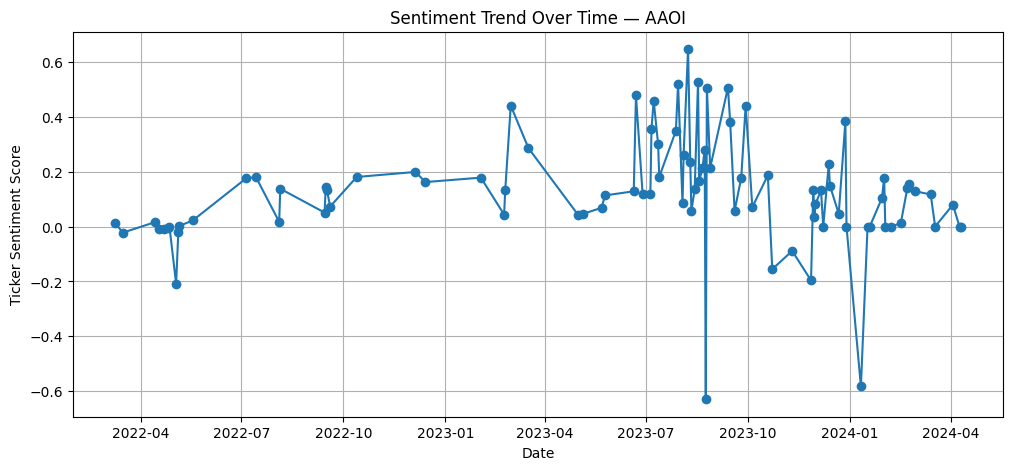

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

def visualize_sentiment_for_ticker(sentiment_csv_path, ticker_symbol):
    df = pd.read_csv(sentiment_csv_path)
    df['time_published'] = pd.to_datetime(df['time_published'], format='%Y%m%dT%H%M%S', errors='coerce')
    df = df.dropna(subset=['time_published'])

    # Filter for the specific ticker
    ticker_df = df[df['ticker'] == ticker_symbol.upper()]

    if ticker_df.empty:
        print(f"❌ No sentiment data found for ticker '{ticker_symbol}'")
        return

    print(f"\n📊 Showing sentiment trend for: {ticker_symbol}")
    print(f"📰 Number of news articles: {len(ticker_df)}")

    # Group by day and calculate mean ticker sentiment score
    daily_sentiment = ticker_df.groupby(ticker_df['time_published'].dt.date)['ticker_sentiment_score'].mean()

    # Plotting
    plt.figure(figsize=(12, 5))
    plt.plot(daily_sentiment.index, daily_sentiment.values, marker='o')
    plt.title(f"Sentiment Trend Over Time — {ticker_symbol}")
    plt.xlabel("Date")
    plt.ylabel("Ticker Sentiment Score")
    plt.grid()
    plt.show()

# Example usage:
visualize_sentiment_for_ticker("sentiments.csv", "AAOI")



📊 Showing sentiment trend for: AAL
📰 Number of news articles: 925


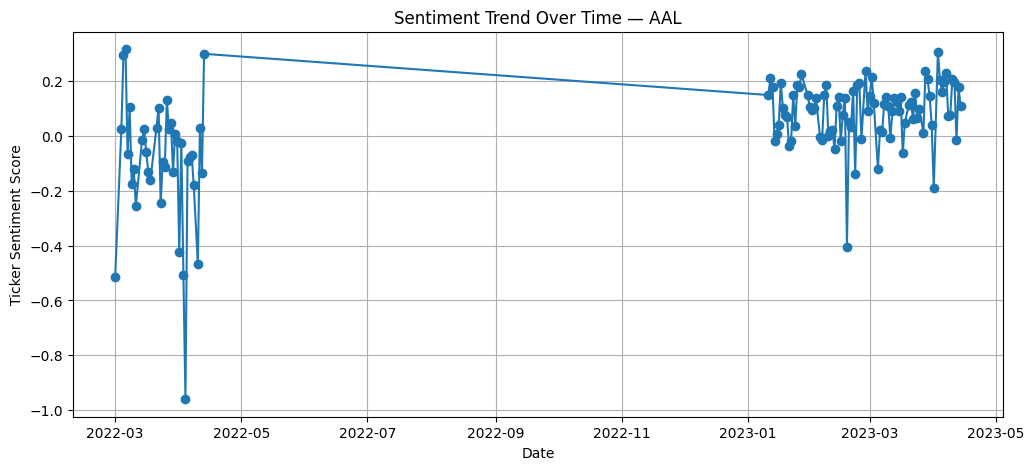

In [6]:
visualize_sentiment_for_ticker("sentiments.csv", "AAL")


📊 Showing sentiment trend for: AACG
📰 Number of news articles: 97


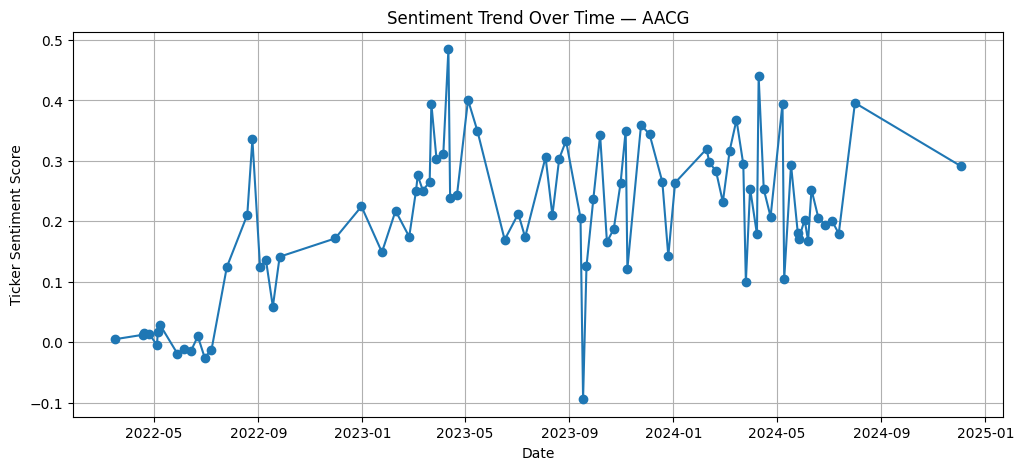

In [7]:
visualize_sentiment_for_ticker("sentiments.csv", "AACG")